## Projet PACTE 4A-IIIA: Data Science Formula 1 World  Championship
### Sujet: L'impact de la position de depart sur le resultat d'une course.

Dans cette étude, nous nous intéressons à l’impact de la position de départ sur le résultat d’une course de Formule 1, en adoptant une approche basée sur l’analyse descriptive des données. L’objectif est de comprendre comment la position de départ influence les performances des pilotes, tout en explorant des facteurs connexes tels que les classements cumulés et les performances individuelles.

Pour cette analyse, nous utilisons plusieurs fichiers issus de la base de données Formula 1, chacun apportant des informations complémentaires :  

- **`lap_times.csv`** : Contient les temps au tour pour chaque pilote, permettant d’examiner la régularité et la performance au cours de la course.  
- **`qualifying.csv`** : Fournit les résultats des qualifications, y compris les temps enregistrés dans chaque session, et aide à relier les positions de départ aux performances en course.  
- **`races.csv`** : Offre des informations contextuelles sur chaque Grand Prix, telles que l’année, le lieu, et le circuit.  
- **`results.csv`** : Détaille les résultats spécifiques de chaque course, comme la position finale, les points marqués et les incidents de course.  
- **`status.csv`** : Indique les raisons de l’abandon ou de l’échec pour certains pilotes, utile pour analyser les événements qui perturbent les performances.  
- **`driver_standings.csv`** : Résume le classement global des pilotes après chaque course, incluant les points accumulés et les victoires totales. Ce fichier nous permet d’intégrer une perspective cumulative pour évaluer l’impact des résultats individuels sur le championnat.  

Les variables pertinentes que nous analyserons incluent :  
1. **`grid`** (fichier `results.csv`) : Position de départ sur la grille, essentielle pour comprendre son influence sur les performances en course.  
2. **`positionOrder`** (fichier `results.csv`) : Position finale à l’arrivée, pour évaluer les progrès ou les déclins des pilotes pendant la course.  
3. **`points`** (fichier `driver_standings.csv`) : Points cumulés par pilote, pour relier les performances individuelles à l’évolution globale du championnat.  
4. **`milliseconds`** (fichier `lap_times.csv`) : Temps au tour en millisecondes, pour analyser la constance des pilotes et détecter les variations de performance.  
5. **`q3`** (fichier `qualifying.csv`) : Temps réalisé lors de la troisième session de qualification, clé pour déterminer la position de départ.  
6. **`status`** (fichier `status.csv`) : Raison de l’abandon ou du résultat, pour comprendre les incidents et leur impact sur les classements.  

En analysant ces variables, nous espérons identifier des tendances et corrélations qui éclairent le rôle des qualifications, des performances en course, et des incidents dans les résultats finaux.  

In [59]:
import pandas as pd

#### 1. Chargement des données

In [61]:
lap_times = pd.read_csv("./dataset/lap_times.csv")
qualifying = pd.read_csv("./dataset/qualifying.csv") 
races = pd.read_csv("./dataset/races.csv")
results = pd.read_csv("./dataset/results.csv")
status = pd.read_csv("./dataset/status.csv")

##### Verification de chargement

In [63]:
# Vérification des datasets importés
datasets = {
    "lap_times": lap_times,
    "qualifying": qualifying,
    "races": races,
    "results": results,
    "status": status
}

for name, df in datasets.items():
    print(f"{name}: {df.shape[0]} lignes, {df.shape[1]} colonnes")

lap_times: 575029 lignes, 6 colonnes
qualifying: 10254 lignes, 9 colonnes
races: 1125 lignes, 18 colonnes
results: 26519 lignes, 18 colonnes
status: 139 lignes, 2 colonnes


#### 2. Préparation des données

#### 2.1. Exploration initiale des données
Cette étape permet d’avoir une vue d’ensemble des datasets (colonnes, types de données, valeurs manquantes).

In [65]:
# Afficher les premières lignes et résumés des datasets
for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(df.info())
    print(df.head(), "\n")


Dataset: lap_times
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575029 entries, 0 to 575028
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        575029 non-null  int64 
 1   driverId      575029 non-null  int64 
 2   lap           575029 non-null  int64 
 3   position      575029 non-null  int64 
 4   time          575029 non-null  object
 5   milliseconds  575029 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 26.3+ MB
None
   raceId  driverId  lap  position      time  milliseconds
0     841        20    1         1  1:38.109         98109
1     841        20    2         1  1:33.006         93006
2     841        20    3         1  1:32.713         92713
3     841        20    4         1  1:32.803         92803
4     841        20    5         1  1:32.342         92342 

Dataset: qualifying
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10254 entries, 0 to 10253
Data columns (total

##### 2.2. Recherche de valeurs dupliquées
Vérifier qu'il n'y a pas de doublons dans les données. S'il y en a, supprimer les lignes redondantes.

In [67]:
for name, df in datasets.items():
    duplicates = df.duplicated().sum()
    
    if duplicates > 0:
        df_clean = df.drop_duplicates()
        datasets[name] = df_clean  # Update the dictionary with the cleaned DataFrame
        print(f"Doublons supprimés dans le dataset: {name}")
    else:
        print(f"Aucune valeur dupliquée dans le dataset: {name}")


Aucune valeur dupliquée dans le dataset: lap_times
Aucune valeur dupliquée dans le dataset: qualifying
Aucune valeur dupliquée dans le dataset: races
Aucune valeur dupliquée dans le dataset: results
Aucune valeur dupliquée dans le dataset: status


##### 2.3. Traitement des valeurs manquantes
Les valeurs manquantes peuvent fausser les résultats. On identifie ces valeurs et choisit une stratégie : suppression, imputation, ou autre.

In [69]:
# Vérification des valeurs manquantes
for name, df in datasets.items():
    print(f"{name} - Valeurs manquantes:\n{df.isnull().sum()}\n")

lap_times - Valeurs manquantes:
raceId          0
driverId        0
lap             0
position        0
time            0
milliseconds    0
dtype: int64

qualifying - Valeurs manquantes:
qualifyId         0
raceId            0
driverId          0
constructorId     0
number            0
position          0
q1                0
q2               13
q3               27
dtype: int64

races - Valeurs manquantes:
raceId         0
year           0
round          0
circuitId      0
name           0
date           0
time           0
url            0
fp1_date       0
fp1_time       0
fp2_date       0
fp2_time       0
fp3_date       0
fp3_time       0
quali_date     0
quali_time     0
sprint_date    0
sprint_time    0
dtype: int64

results - Valeurs manquantes:
resultId           0
raceId             0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionText       0
positionOrder      0
points             0
laps               0
time      

##### 2.3.1. Afficher le nbr de valeurs manquantes par variable

In [71]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

for name, df in datasets.items():
    print(f"{name} - Valeurs manquantes par variable:")
    print(df.isna().sum())
    print("\n")

lap_times - Valeurs manquantes par variable:
raceId          0
driverId        0
lap             0
position        0
time            0
milliseconds    0
dtype: int64


qualifying - Valeurs manquantes par variable:
qualifyId         0
raceId            0
driverId          0
constructorId     0
number            0
position          0
q1                0
q2               13
q3               27
dtype: int64


races - Valeurs manquantes par variable:
raceId         0
year           0
round          0
circuitId      0
name           0
date           0
time           0
url            0
fp1_date       0
fp1_time       0
fp2_date       0
fp2_time       0
fp3_date       0
fp3_time       0
quali_date     0
quali_time     0
sprint_date    0
sprint_time    0
dtype: int64


results - Valeurs manquantes par variable:
resultId           0
raceId             0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionText       0
positionOrder     

In [73]:
for name, df in datasets.items():
    for column in df.columns:
        missing = df[column].isna().sum()
        if missing > 0:
            print(f"{name} - {column}: {missing}")


qualifying - q2: 13
qualifying - q3: 27


##### 2.3.2. Calculons le pourcentage de valeurs manquante dans toute la data

In [75]:
for name, df in datasets.items():
    total_missing = df.isna().sum().sum()
    total_values = df.size
    missing_percentage = (total_missing / total_values) * 100

    print(f"\nPourcentage total de valeurs manquantes pour {name}: {missing_percentage:.2f}%")



Pourcentage total de valeurs manquantes pour lap_times: 0.00%

Pourcentage total de valeurs manquantes pour qualifying: 0.04%

Pourcentage total de valeurs manquantes pour races: 0.00%

Pourcentage total de valeurs manquantes pour results: 0.00%

Pourcentage total de valeurs manquantes pour status: 0.00%


##### 2.3.3. Calculer le pourcentage de valeurs manquantes pour chaque colonne.

In [77]:
for name, df in datasets.items():
    missing_percentage_by_column = (df.isna().sum() / len(df)) * 100
    print(f"\nPourcentage de valeurs manquantes par colonne pour {name}:")
    print(missing_percentage_by_column[missing_percentage_by_column > 0])



Pourcentage de valeurs manquantes par colonne pour lap_times:
Series([], dtype: float64)

Pourcentage de valeurs manquantes par colonne pour qualifying:
q2    0.126780
q3    0.263312
dtype: float64

Pourcentage de valeurs manquantes par colonne pour races:
Series([], dtype: float64)

Pourcentage de valeurs manquantes par colonne pour results:
Series([], dtype: float64)

Pourcentage de valeurs manquantes par colonne pour status:
Series([], dtype: float64)


##### 2.3.4. Imputation par la valeur la plus fréquente (mode) 

In [79]:
# Imputation par la valeur la plus fréquente pour q2 et q3
qualifying['q2'] = qualifying['q2'].fillna(qualifying['q2'].mode()[0])
qualifying['q3'] = qualifying['q3'].fillna(qualifying['q3'].mode()[0])

# Vérification de l'impact de l'imputation
print(qualifying.isna().sum())


qualifyId        0
raceId           0
driverId         0
constructorId    0
number           0
position         0
q1               0
q2               0
q3               0
dtype: int64


On ramarque qu'il n'y a plus de valeurs manquantes dans le dataset pour les colonnes spécifiées (q2 et q3)! 
Cela signifie que toutes les valeurs manquantes ont été correctement imputées.
La méthode d'imputation par la valeur la plus fréquente a donc été efficace dans ce cas.

#### 3. Analyse descriptive des données

##### 3.1. Statistiques descriptives
Fournir des statistiques (moyenne, médiane, écart-type, etc.) pour comprendre la distribution des variables.

In [81]:
# Analyse statistique descriptive pour chaque dataset
for name, df in datasets.items():
    print(f"\n--- Statistiques descriptives pour {name} ---")
    print(df.describe())  # Affiche les statistiques de base (moyenne, médiane, etc.)
    
    # Pour les variables non numériques, on peut aussi obtenir des informations comme le nombre de valeurs uniques
    print(f"\nValeurs uniques pour {name} :")
    print(df.nunique())


--- Statistiques descriptives pour lap_times ---
              raceId       driverId            lap       position  \
count  575029.000000  575029.000000  575029.000000  575029.000000   
mean      587.413494     315.316934      30.021122       9.659650   
std       431.352273     384.339100      18.417608       5.531594   
min         1.000000       1.000000       1.000000       1.000000   
25%       137.000000      15.000000      14.000000       5.000000   
50%       855.000000      44.000000      29.000000       9.000000   
75%       993.000000     820.000000      44.000000      14.000000   
max      1131.000000     860.000000      87.000000      24.000000   

       milliseconds  
count  5.750290e+05  
mean   9.580980e+04  
std    7.692607e+04  
min    5.540400e+04  
25%    8.196200e+04  
50%    9.062700e+04  
75%    1.019710e+05  
max    7.507547e+06  

Valeurs uniques pour lap_times :
raceId            531
driverId          141
lap                87
position           24
time    

##### 3.2. Visualisation des Données
Pour la visualisation, on peut utiliser matplotlib et seaborn pour créer des graphiques comme des histogrammes, des diagrammes en boîte, et des nuages de points.

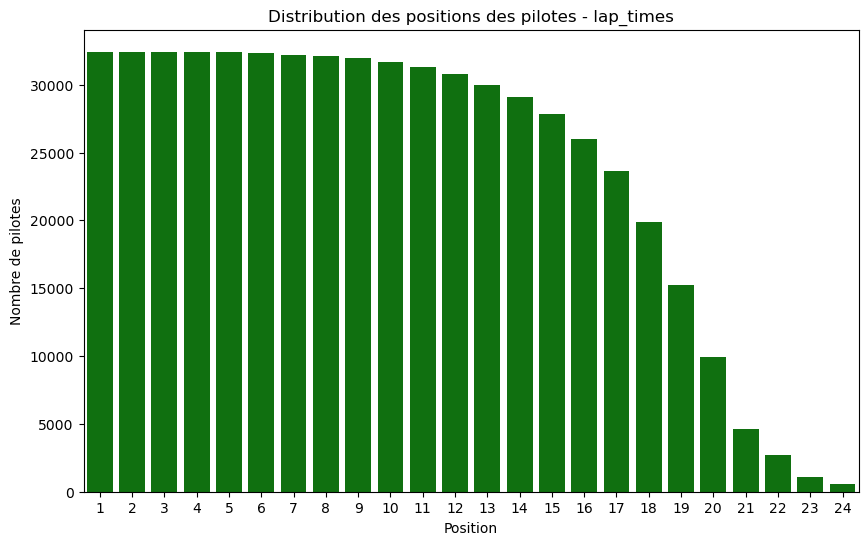

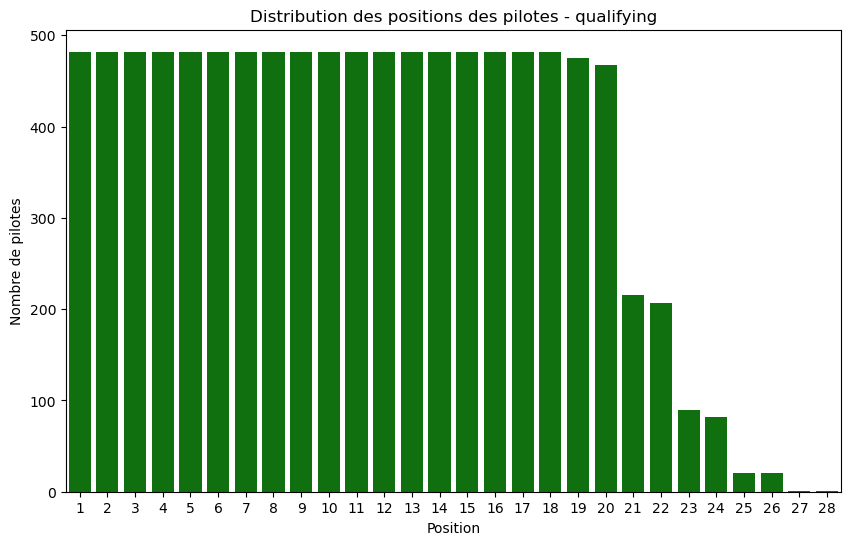

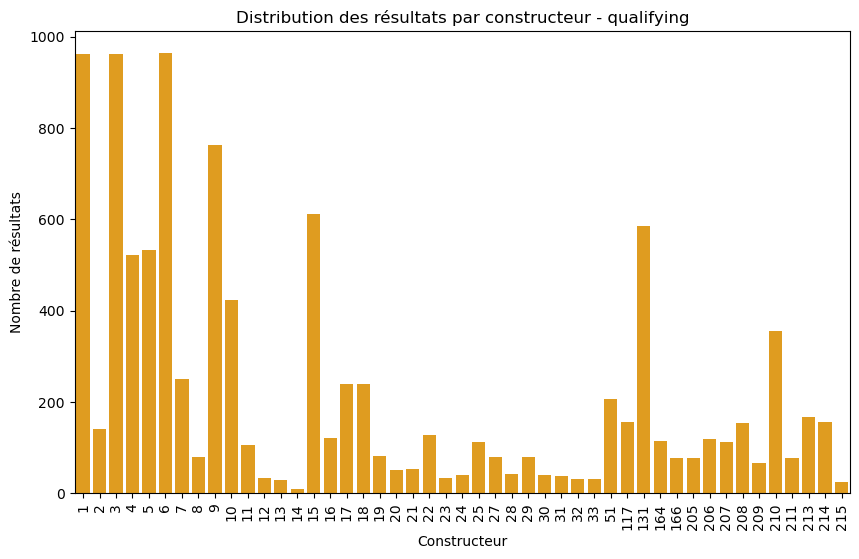

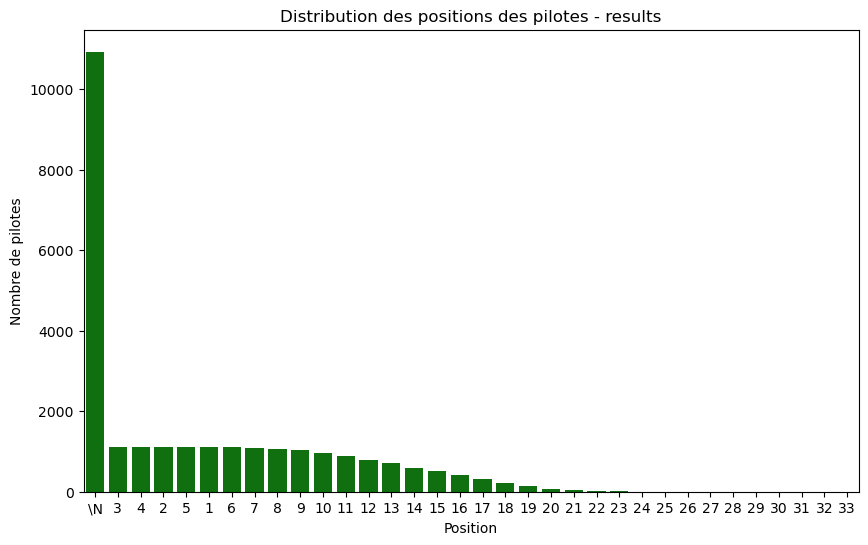

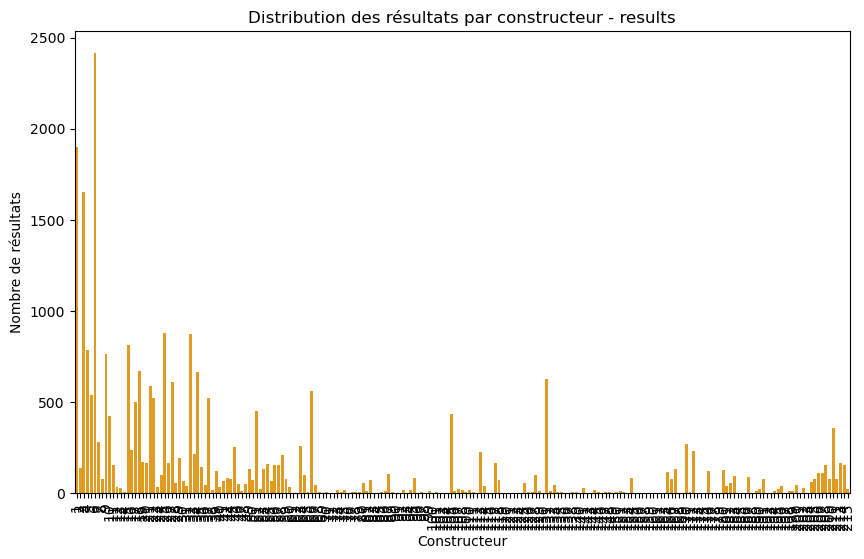

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour créer un histogramme des temps de tour (par exemple pour 'lap_times')
def plot_histogram_lap_times(df, name):
    if 'lapTime' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['lapTime'], kde=True, bins=30, color='blue')
        plt.title(f"Histogramme des temps de tour - {name}")
        plt.xlabel('Temps de tour')
        plt.ylabel('Fréquence')
        plt.show()

# Fonction pour créer un diagramme à barres des positions des pilotes (par exemple pour 'qualifying')
def plot_bar_positions(df, name):
    if 'position' in df.columns:
        position_counts = df['position'].value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=position_counts.index, y=position_counts.values, color='green')
        plt.title(f"Distribution des positions des pilotes - {name}")
        plt.xlabel('Position')
        plt.ylabel('Nombre de pilotes')
        plt.show()

# Fonction pour analyser les résultats par constructeur (exemple avec 'results')
def plot_bar_constructor_results(df, name):
    if 'constructorId' in df.columns:
        constructor_counts = df['constructorId'].value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=constructor_counts.index, y=constructor_counts.values, color='orange')
        plt.title(f"Distribution des résultats par constructeur - {name}")
        plt.xlabel('Constructeur')
        plt.ylabel('Nombre de résultats')
        plt.xticks(rotation=90)
        plt.show()

# Appliquer les visualisations pour chaque dataset
for name, df in datasets.items():
    plot_histogram_lap_times(df, name)   # Histogramme des temps de tour
    plot_bar_positions(df, name)         # Diagramme à barres des positions
    plot_bar_constructor_results(df, name)  # Diagramme à barres des résultats par constructeur
